<a href="https://colab.research.google.com/github/lukedalmau/computer-science-bachelor-thesis/blob/main/notebooks/tesis_generacion_lsc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Generación de avatares para la Lengua de Señas Cubana(LSC)

### Pasos a seguir
- Ejecutar la celda de Instanciacion
  - Revisar las rutas
- Si no se tiene el dataset descargado debe usarse el boton descargar datos del s3
- Metodos utiles 
- Animaciones con Matplotlib
- Cargar los json si no se guardo el dataset.json en el drive
- (Opcional) Usar la celda de Bolsa de Palabras para ver la naturaleza del corpus
- Metodos de Animaciones
-(Opcional) Guardar todas las Videoanimaciones
- Importar Word2Vec
- Diseño del modelo completo hasta el Kfold
  - Si se tiene los pesos descargados usen model.load_weights(dir)
- Probar el modelo insertando una palabra y visualizando el resultado

## Instanciación

In [72]:
#@markdown ### Montar drive de Google
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [73]:
#@markdown ### Chequear versión de Python
!python --version

Python 3.7.15


In [74]:
#@markdown ### Dependencias
!pip install awscli botocore boto3 torch torchvision torchaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [75]:
#@markdown ### Importar bibliotecas
from boto3 import client
from botocore.config import Config
from pathlib import Path
import os
import boto3
import numpy as np
import json
import re
import shutil
import math
import json
from IPython.display import HTML

In [76]:
#@markdown ### Instanciar rutas y datos
root = Path("/content") 
droot = Path("/content/drive/MyDrive")

landmarks_path = "lsc/landmarks/"

root_tesis = (root/f"tesis-generacion-lsc/").resolve()
droot_tesis = (droot/f"tesis-generacion-lsc/").resolve()


cendsor_path = "cendsor-corpus/keypoints/"

pose_videos_dir=(root_tesis/"pose_videos/")
dpose_videos_dir=(droot_tesis/"pose_videos/")

fps=24

body_dim = 25*3
left_dim = 21*3
right_dim = 21*3

dims=[(25,3),(21,3),(21,3)]

bodyjoints=[[1,7],[4,8],[9,10],[11,12],[11,13],[12,14],[11,23],[12,24],[23,24],[13,15],[14,16]]
leftjoints=[[0,1],[1,2],[2,3],[3,4],
            [0,5],[5,6],[6,7],[7,8],
            [5,9],[9,10],[10,11],[11,12],
            [9,13],[13,14],[14,15],[15,16],
            [13,17],[17,18],[18,19],[19,20],[0,17]]
rightjoints=leftjoints

fullbodyjoints=[bodyjoints,leftjoints,rightjoints]

parts_names=["body","left","right"]

bucket = "ntv-lsc-corpus"
working_folder = "tesis-generacion-lsc/data"


In [77]:
#@markdown ### Instanciar cliente s3
s3_client = client(
    "s3",
    config=Config(
        signature_version="s3v4",
        retries={"max_attempts": 10},
        s3={"addressing_style": "path"},
    ),
    region_name="ams3",
    endpoint_url="https://ams3.digitaloceanspaces.com",
    aws_access_key_id="DO0092Z7ZRLURR7F9NLT",
    aws_secret_access_key="7IFEvi11ly6e8rR9o2pFZYPaQDQrby/fNP+k/ZGn/YU",
)

## Descargar los datos del s3

In [ ]:
#@markdown ### Listar los buckets en el s3
list_of_buckets=[[value for key,value in lst.items() if key=='Name'] for lst in s3_client.list_buckets()["Buckets"]]
bucket_names=[item[0] for item in list_of_buckets if item[0]!='mesirve']
bucket_names

['lsc-corpus', 'ntv-lsc-corpus']

In [ ]:
#@markdown ### Revisar tamaño del dataset a descargar

paginator = s3_client.get_paginator('list_objects_v2')
pages = paginator.paginate(Bucket="lsc-corpus")

s3_files_list=[]

for page in pages:
    for obj in page['Contents']:
        extension = obj['Key'].split('.')[-1]
        name=obj['Key'].split('.')[0]
        if extension  in ['json']:
          if "dataset" in name:continue
          print(obj['Key'],round(obj['Size']/(1024**2),2),'MB')
          print(bucket)
          s3_files_list.append(obj['Key'])

for s3_file in s3_files_list:
  drivepath=(root/f"tesis-generacion-lsc/{s3_file}").resolve()
  (drivepath/'..').resolve().mkdir(parents=True,exist_ok=True)
  drivepath.touch()
  s3_client.download_file(bucket,s3_file,str(drivepath))

cendsor-corpus/keypoints/abandonar.json 0.65 MB
lsc-corpus
cendsor-corpus/keypoints/abierto.json 0.23 MB
lsc-corpus
cendsor-corpus/keypoints/abono.json 0.67 MB
lsc-corpus
cendsor-corpus/keypoints/aborto (2).json 0.55 MB
lsc-corpus
cendsor-corpus/keypoints/aborto.json 0.5 MB
lsc-corpus
cendsor-corpus/keypoints/abril.json 0.17 MB
lsc-corpus
cendsor-corpus/keypoints/abuelo.json 0.21 MB
lsc-corpus
cendsor-corpus/keypoints/abusar.json 0.58 MB
lsc-corpus
cendsor-corpus/keypoints/acampada.json 0.67 MB
lsc-corpus
cendsor-corpus/keypoints/accesorio.json 0.59 MB
lsc-corpus
cendsor-corpus/keypoints/accion.json 0.51 MB
lsc-corpus
cendsor-corpus/keypoints/aceituna.json 0.6 MB
lsc-corpus
cendsor-corpus/keypoints/aceleracion (2).json 0.67 MB
lsc-corpus
cendsor-corpus/keypoints/aceleracion.json 0.53 MB
lsc-corpus
cendsor-corpus/keypoints/aceptar (2).json 0.19 MB
lsc-corpus
cendsor-corpus/keypoints/aceptar.json 0.43 MB
lsc-corpus
cendsor-corpus/keypoints/aconsejar.json 0.61 MB
lsc-corpus
cendsor-corpus

In [ ]:
#@markdown ## Tips comentados a revisar de pathlib
# path = Path("/content/drive/My Drive/config/awscli.ini")
# (path / "..").resolve().mkdir(parents=True, exist_ok=True)
# path.touch(exist_ok=True)
# path.write_text(text)

In [ ]:
#@markdown ### Descargar del s3 a local
# Path(working_folder).mkdir(parents=True, exist_ok=True)

# if not os.path.exists(local_X_train_file):
#     s3_client.download_file(bucket, remote_X_train_file, local_X_train_file)

# if not os.path.exists(local_y_train_file):
#     s3_client.download_file(bucket, remote_y_train_file, local_y_train_file)

# if not os.path.exists(local_X_test_file):
#     s3_client.download_file(bucket, remote_X_test_file, local_X_test_file)

# if not os.path.exists(local_y_test_file):
#     s3_client.download_file(bucket, remote_y_test_file, local_y_test_file)

## Revisar los datos X y

In [ ]:
#@markdown ### Cargar el conjunto de features y targets entrenantes y de testeo 

# with open(local_X_train_file, "rb") as f:
#     X_train = np.load(f)

# with open(local_y_train_file, "rb") as f:
#     y_train = np.load(f)

# with open(local_X_test_file, "rb") as f:
#     X_test = np.load(f)

# with open(local_y_test_file, "rb") as f:
#     y_test = np.load(f)

## Metodos Utiles

In [78]:
def extract_3d_shape(array,dims):
      init=0
      ending=0
      parts=[]
      for dim in dims:
        ending+=dim[0]*dim[1]
        parts.append(array[:,init:ending].reshape((array.shape[0],dim[0],dim[1])))
        init+=dim[0]*dim[1]

      single_gesture={parts_names[i]:parts[i] for i in range(len(dims))}

      return single_gesture

## Animaciones con Matplotlib

In [79]:
#@markdown ### Importar bibliotecas
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib import rc
import numpy as np
import matplotlib.cm as cm

In [80]:
#@markdown ### Método para transformar los datos
def transform_data(Data,i):
    from scipy.spatial.transform import Rotation as R

    r = R.from_rotvec(np.pi/2 * np.array([0,0,1]))

    X=np.array(Data[i,:,0])
    Y=np.array(-Data[i,:,1])
    Z=np.array(Data[i,:,2])

    meanpoint=(X[X!=0].mean(),Y[Y!=0].mean(),Z[Z!=0].mean())

    D = np.array([x if x!=(0.0,0.0,0.0) else meanpoint for x in zip(X, Y, Z) ])
    D = r.apply(D)
    return D

In [81]:
#@markdown ### Realizar la animacion
def animate(Data,frames=None,figsize=(7.0,3.5),elev=None,angle=None,dims=dims,text=False,joints=False):
  rc('animation',html='jshtml')
  fig_size_x,fig_size_y=figsize

  plt.rcParams["figure.figsize"]= [fig_size_x,fig_size_y]
  plt.rcParams['figure.autolayout']= True

  fig = plt.figure()
  ax = fig.add_subplot(projection='3d')
  colors=['b','y','r','k']
  
  def update(i):
    ax.clear()
    
    D=transform_data(Data,i)

    s=0
    e=0
    for j, dim in enumerate(dims):
      dim = dim[0]
      e+=dim

      x=D[s:e,0]
      y=D[s:e,1]
      z=D[s:e,2]

      ax.plot(D[s:e,0],D[s:e,1],D[s:e,2],f'{colors[j]}.')
      if text:
        for p in range(s,e):
          ax.text3D(D[p,0],D[p,1],D[p,2],str(p))
      if joints:
        for h,k in fullbodyjoints[j]:
          ax.plot([D[s+h,0],D[s+k,0]],[D[s+h,1],D[s+k,1]],[D[s+h,2],D[s+k,2]],f'{colors[j]}')
      s+=dim

    ax.set_axis_off()
    if elev and angle:
      ax.view_init(elev,angle) 

    
    return ax

  if frames is None:
    frames=24
  return FuncAnimation(fig,update,frames=frames,repeat=True)

In [82]:
#@markdown ### Método para comparar plots
def compareplots(Data,VsData,frames=None,figsize=(7.0,3.5),elev=90,angle=1,dims=dims,text=False,joints=False):
  fig_size_x,fig_size_y=figsize

  plt.rcParams["figure.figsize"]= [fig_size_x,fig_size_y]
  plt.rcParams['figure.autolayout']= True

  fig,axes = plt.subplots(2 , Data.shape[0],sharex=True,subplot_kw=dict(projection='3d'))
  
  colors=['b','y','r','k']

  for i,p in zip(range(Data.shape[0]),range(VsData.shape[0])):

    D = transform_data(Data,i)
    VsD= transform_data(VsData,p)

    s=0
    e=0
    for j, dim in enumerate(dims):
      dim = dim[0]
      e+=dim

      axes[0][i].plot(D[s:e,0],D[s:e,1],D[s:e,2],f'{colors[j]}.')

      axes[1][p].plot(VsD[s:e,0],VsD[s:e,1],VsD[s:e,2],f'{colors[j]}.')
      if text:
        for h in range(s,e):
          axes[0][i].text3D(D[h,0],D[h,1],D[h,2],str(h))
          axes[1][p].text3D(VsD[h,0],VsD[h,1],VsD[h,2],str(h))
      if joints:
        for h,k in fullbodyjoints[j]:
          axes[0][i].plot([D[s+h,0],D[s+k,0]],[D[s+h,1],D[s+k,1]],[D[s+h,2],D[s+k,2]],f'{colors[j]}')
          axes[1][p].plot([VsD[s+h,0],VsD[s+k,0]],[VsD[s+h,1],VsD[s+k,1]],[VsD[s+h,2],VsD[s+k,2]],f'{colors[j]}')
      s+=dim
      if elev and angle:
        axes[0][i].view_init(elev,angle) 
        axes[1][p].view_init(elev,angle)

      axes[0][i].set_axis_off()
      axes[1][p].set_axis_off()

      axes[0][i].set_yticks="Predicted"
      axes[1][p].set_yticks="Ground Truth"

    


## Cargar los json para probar

In [ ]:

npzroot_cendsor=Path(root_tesis/cendsor_path/f"npz/")

npzroot_cendsor.resolve().mkdir(parents=True,exist_ok=True)
shutil.rmtree((npzroot_cendsor).resolve())
npzroot_cendsor.resolve().mkdir(parents=True,exist_ok=True)

counter=0

word_poses_dict={}

for dirpath,dirnames,filenames in os.walk(root_tesis/cendsor_path):
  if "/npz" in dirpath:continue
  for filename in filenames:
    key,extension=filename.split('.')

    if extension in ['npz','npy']:continue
    if key in ['dataset']:continue
    
    counter+=1
    key=re.sub(r"\s*\(.*\)","",key)
    key= key.replace("nn",'ñ')
    key=re.sub(r"\s?\d","",key)
    key = key.replace("-"," ") 
    #key = key.replace(" ","_") #Formando los n-gramas

    with open((root_tesis/cendsor_path/filename).resolve(), 'r', encoding='utf-8') as json_list:
      poseframes=np.array(json.load(json_list))
      json_list.close()
      #print(filename)

      filtro = [m!=0.0 for m in  np.mean(poseframes, axis=1)]
      
      poseframes=poseframes[filtro]

      total_frames = poseframes.shape[0]

      n = math.floor(total_frames/fps)

      poseframes= poseframes[::n,:]

      while poseframes.shape[0]>24:
        if poseframes.shape[0]%2:
          poseframes=poseframes[1:,:]
        else:
           poseframes=poseframes[:-1,:]

      single_gesture = poseframes.tolist()
      try:
        word_poses_dict[key].append(single_gesture)
      except:
        word_poses_dict[key]=[single_gesture]
      
      npz_cendsor_file=(npzroot_cendsor/f"{key}.npz")
      
      np.savez_compressed(npz_cendsor_file.resolve(), gestures_dict_list=word_poses_dict[key])
      #np.load(file)["face"]

In [ ]:
counter

1293

In [ ]:
#np.savez_compressed((npzroot_cendsor/'../dataset.npz').resolve(),dataset=word_poses_dict,)

In [ ]:
with open((npzroot_cendsor/'../dataset.json').resolve(), 'w', encoding='utf-8') as json_file:
  json.dump(word_poses_dict,json_file,indent=4,sort_keys=True, ensure_ascii=False)
  json_file.close()

In [ ]:
with open((droot_tesis/'dataset.json').resolve(), 'w', encoding='utf-8') as json_file:
  json.dump(word_poses_dict,json_file,indent=4,sort_keys=True, ensure_ascii=False)
  json_file.close()

In [ ]:
np.array(word_poses_dict.get('promesa')).shape

(1, 24, 201)

In [ ]:
len(word_poses_dict)

1049

## Seccion de Comentarios

In [ ]:
#@markdown Comment
#!unzip /content/tesis-generacion-lsc/landmarks.zip

In [ ]:
#@markdown  Comment
# word_poses_dict={}

# npzroot=Path(root/landmarks_path/f"npz/")

# npzroot.resolve().mkdir(parents=True,exist_ok=True)
# shutil.rmtree((npzroot).resolve())
# npzroot.resolve().mkdir(parents=True,exist_ok=True)

# for dirpath,dirnames,filenames in os.walk(root/landmarks_path):
#   for filename in filenames:
#     key,extension=filename.split('.')
#     if extension in ['npz','json']:continue
#     key=re.sub(r"\s*\(.*\)","",key)
#     key= key.replace("nn",'ñ')
#     key=re.sub(r"\s?\d","",key)
#     with open((root/landmarks_path/filename).resolve(),"rb") as landmark_file:
#       landmark_array=np.load(landmark_file)
#       init=0
#       ending=0
      
#       ending+=face_dim
#       face=landmark_array[:,init:ending].reshape((landmark_array.shape[0],468,3))
#       face=face.tolist()

#       init+=face_dim
#       ending+=body_dim
#       body=landmark_array[:,init:ending].reshape((landmark_array.shape[0],33,3))
#       body = body.tolist()

#       init+=body_dim
#       ending+=left_dim
#       left = landmark_array[:,init:ending].reshape((landmark_array.shape[0],21,3))
#       left= left.tolist()

#       init+=left_dim
#       ending+=right_dim
#       right = landmark_array[:,init:ending].reshape((landmark_array.shape[0],21,3))
#       right=right.tolist()

#       single_gesture={'face':face,'body':body,'right':right,'left':left}

#       try:
#         word_poses_dict[key]=[single_gesture]
#       except:
#         word_poses_dict[key].append(single_gesture)
      
#       npzfile=(npzroot/f"{key}.npz")
      
#       np.savez_compressed(npzfile.resolve(), gestures_dict_list=word_poses_dict[key])
#       #np.load(file)["face"]

In [ ]:
#@markdown Comment
# np.savez_compressed((npzroot/'../dataset.npz').resolve(),dataset=word_poses_dict,)

In [ ]:
#@markdown Comment
# with open((npzroot/'../dataset.json').resolve(), 'w', encoding='utf-8') as json_file:
#   json.dump(word_poses_dict,json_file,indent=4,sort_keys=True, ensure_ascii=False)
#   json_file.close()

In [ ]:
#@markdown Comment
# len(word_poses_dict)

In [ ]:
#@markdown Comment
# np.array(word_poses_dict.get('facebook')[0]).shape

## Cargar dataset.json de Drive

In [83]:
dataset=None
with open((droot_tesis/"dataset.json").resolve(), 'r', encoding='utf-8') as json_list:
      dataset=json.load(json_list)
      json_list.close()

## Bolsa de palabras del corpus

In [ ]:
len_words = np.array([len(key.split(" ")) for key in dataset.keys()])
len_values = np.array([len(value) for value in dataset.values()])

print("values", "min", len_values.min() ,"mean", len_values.mean(), "max",len_values.max())
repeated=[(len(value),key) for key,value in dataset.items()]
print(repeated)
repeated.sort(reverse=True)
print(repeated)
print()
print("keys","min", len_words.min() ,"mean", len_words.mean(), "max",len_words.max())
print([key for key in dataset.keys() if len(key.split(" "))==len_words.min() ])
print([key for key in dataset.keys() if len(key.split(" "))==len_words.max() ])
bag = set()
for key in dataset.keys():
  for l in key:
    bag.add(l)

ordered_bag=[c for c in bag]
ordered_bag.sort()
print(ordered_bag,len(ordered_bag))

feature_vocab=ordered_bag

values min 1 mean 1.232602478551001 max 4
[(1, 'abandonar'), (1, 'abierto'), (1, 'abono'), (2, 'aborto'), (1, 'abril'), (1, 'abuelo'), (1, 'abusar'), (1, 'acampada'), (1, 'accesorio'), (1, 'accion'), (1, 'aceituna'), (2, 'aceleracion'), (2, 'aceptar'), (1, 'aconsejar'), (1, 'acordar'), (2, 'acta'), (1, 'acto'), (2, 'actuar'), (1, 'acuatico'), (1, 'adaptacion'), (1, 'adjetivo'), (2, 'adulto'), (1, 'adverbio'), (1, 'aeropuerto'), (1, 'afeitar'), (1, 'agosto'), (1, 'aguila'), (1, 'ahijado'), (1, 'ahora'), (1, 'ahora mismo'), (1, 'aire'), (2, 'ajedrez'), (1, 'ajo'), (1, 'alcohol'), (1, 'alfiler'), (2, 'algo'), (1, 'alguno'), (1, 'almacen'), (1, 'almohada'), (1, 'alrededor'), (1, 'aluminio'), (1, 'amante'), (1, 'amar'), (1, 'amarillo'), (2, 'america'), (1, 'america central'), (1, 'america del norte'), (1, 'america del sur'), (1, 'amigo'), (1, 'amor'), (3, 'analizar'), (1, 'antes'), (2, 'antiguo'), (1, 'antonimo'), (1, 'aparador'), (1, 'aparecer'), (1, 'apego'), (1, 'apertura'), (2, 'aplaudi

## Metodos de Animaciones

In [84]:
def plotanimation(result):
  if result.shape[2]==201:
    dict_parts=extract_3d_shape(result[0],dims)    
    body_frames = dict_parts["body"]
    left_frames = dict_parts["left"]
    right_frames = dict_parts["right"]

    result = np.hstack((body_frames,left_frames,right_frames))

  a=animate(result,result.shape[0],(12,10),90,1,dims,text=False,joints=True)
  return a


In [85]:
def animation(X,key,i,dir:Path=None ,plot=False):
  a=animate(X,X.shape[0],(6,4),90,1,dims,joints=True)
  if dir:
    a.save((dir/f"{key}_{i}.mp4").resolve())
  if plot:
    HTML(a.to_html5_video())
  plt.close('all')

In [86]:
def videoanimation(j,key,i,gesture,dataset,dims,dir:Path):

  dict_parts=extract_3d_shape(np.array(gesture),dims)
    
  body_frames = dict_parts["body"]
  left_frames = dict_parts["left"]
  right_frames = dict_parts["right"]

  fullbody_frames = np.hstack((body_frames,left_frames,right_frames))
  X=fullbody_frames
  
  print(f'{j+1}/{len(dataset)}',((j+1)/len(dataset))*100,"%")

  print(key)

  if i>0:print(key,i)
  animation(X,key,i,dir)

## Probando Animaciones

In [ ]:
a=np.array(dataset["fabrica"][0])
for frame in a:
  print(len(frame))

In [ ]:
dict_parts=extract_3d_shape(np.array(dataset["abandonar"][0]),dims)
    
body_frames = dict_parts["body"]
left_frames = dict_parts["left"]
right_frames = dict_parts["right"]

fullbody_frames = np.hstack((body_frames,left_frames,right_frames))
X=fullbody_frames
# print(X.shape)

a=animate(X,X.shape[0],(12,10),90,1,dims,text=False,joints=True)
#a.save("test.mp4")
plt.close('all')
#HTML(a.to_html5_video())
a

## Guardar videoanimaciones

In [ ]:
#@markdown ### Limpiar el directorio
pose_videos_dir.resolve().mkdir(parents=True,exist_ok=True)
shutil.rmtree(pose_videos_dir.resolve())
pose_videos_dir.resolve().mkdir(parents=True,exist_ok=True)


In [ ]:
#@markdown ### Limpiar el directorio en Drive
dpose_videos_dir.resolve().mkdir(parents=True,exist_ok=True)
shutil.rmtree(dpose_videos_dir.resolve())
dpose_videos_dir.resolve().mkdir(parents=True,exist_ok=True)

In [ ]:
for j,(key,gesture_list) in enumerate(dataset.items()):
  for i, gesture in enumerate(gesture_list):
    videoanimation(j,key,i,gesture,dataset,dims,dpose_videos_dir)


## Importando Word Embedding en Español de Word2Vec

In [87]:
!pip install nltk gensim

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [88]:
import nltk
from gensim.models import Word2Vec,KeyedVectors

### Modelo Word2Vec de Español

In [89]:
#!wget -q "https://zenodo.org/record/1410403/files/complete_model.zip" -O "/content/complete_model.zip"

In [90]:
if not Path("/content/keyed_vectors.zip").exists():
  !wget -q "https://zenodo.org/record/1410403/files/keyed_vectors.zip" -O "/content/keyed_vectors.zip"

In [91]:
!unzip -n keyed_vectors

Archive:  keyed_vectors.zip


In [92]:
word_vectors = KeyedVectors.load('complete.kv', mmap='r')

In [93]:
wv=word_vectors

In [94]:
vect = wv["rey"] - wv["hombre"] + wv["mujer"]
wv.similar_by_vector(vect,topn=1)

[('reina', 0.7074883580207825)]

## Diseño del modelo y dependencias

In [95]:
!pip install tensorflow tensorflow-addons


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [96]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.layers import Dense, InputLayer, LSTM , Conv1DTranspose, Reshape
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import  MeanSquaredError
from tensorflow_addons.metrics.r_square import RSquare
import tensorflow as tf
import tensorflow_addons as tfa

In [97]:
def get_model(X, y):
    model = Sequential()
    model.add(InputLayer(X.shape[1:]))
    model.add(LSTM(128, return_sequences=True, activation="relu"))
    model.add(LSTM(256, return_sequences=True, activation="relu"))
    model.add(Conv1DTranspose(filters=100,kernel_size=10))
    model.add(LSTM(128, return_sequences=True, activation="relu"))
    model.add(Conv1DTranspose(filters=150,kernel_size=11))
    model.add(LSTM(201,return_sequences=True))
    model.add(Reshape(y.shape[1:]))
    loss = "mae"
    metrics = RSquare()
    model.compile(optimizer='Adam', loss=loss, metrics=metrics)
    return model

## Métodos para obtener el vector de la frase

In [98]:
def find_similar(word, vocab):
  import difflib
  best_match=difflib.get_close_matches(word,vocab)
  if len(best_match) != 0:
    score = difflib.SequenceMatcher(None,word,best_match[0]).ratio()
    return best_match[0],score

In [99]:
def get_vector(key,word_vectors,num_vecs=5):
  wrong_words={'antonimo': 'antónimo',
              'audiologia':'audiología',
              'barsura':'basura',
              'defectologia':'defectología',
              'empanizar':'empanar',
              'insipido': 'insípido',
              'investar':'inventar',
              'lexicologia': 'lexicología',
              'ostion':'ostra',
              'panciencia':'paciencia',
              'policlinica': 'policlínica',
              'querologia':'querología',
              'rehablilitacion':'rehabilitación',
              'sacapunta':'sacapuntas',
              'señacionario':'diccionario',
              'señario':'libro', 
              'zapia':'compartición'}
  vector=np.zeros((num_vecs,word_vectors.vector_size))
  
  for i,word in enumerate(key.split(" ")):
    if word in word_vectors.vocab.keys():

      wordvec = word_vectors[word]
    else:
      word=wrong_words[word]
      nword, similarity = find_similar(word,word_vectors.vocab.keys())
      print(key,"Not Founded")
      print(nword,similarity)

      wordvec = word_vectors[nword]
    vector[i:]=wordvec
  return vector


## Creación de los conjuntos $X$ e $y$

In [100]:
X=[]
y=[]

num_vecs=max([len(key.split(" ")) for key in dataset.keys()])

for key,gestures in dataset.items():
  vector=get_vector(key,word_vectors,num_vecs)
  X.append(vector)#.reshape((num_vecs*word_vectors.vector_size)))
  y.append(np.array(gestures[0]).reshape((fps,sum([dim[0] for dim in dims]),dims[0][1])))

antonimo Not Founded
antónimo 1.0
audiologia Not Founded
audiología 1.0
barsura Not Founded
basura 1.0
defectologia Not Founded
defectología 1.0
empanizar Not Founded
empanar 1.0
insipido Not Founded
insípido 1.0
investar Not Founded
inventar 1.0
lexicologia Not Founded
lexicología 1.0
ostion Not Founded
ostra 1.0
panciencia Not Founded
paciencia 1.0
policlinica Not Founded
policlínica 1.0
querologia Not Founded
querología 1.0
rehablilitacion Not Founded
rehabilitación 1.0
sacapunta Not Founded
sacapuntas 1.0
señacionario Not Founded
diccionario 1.0
señario Not Founded
libro 1.0
zapia Not Founded
compartición 1.0


In [ ]:
len(X[0])

5

## Separando los datos con train_test_split

In [104]:
X,y=(np.array(X),np.array(y))
print(X.shape[1:])
print(y.shape[1:])
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)
#X_traDependenciasin,X_val,y_train,y_val = train_test_split(X_train,y_train,test_size=0.2,random_state=42)

(5, 400)
(24, 67, 3)


## Haciendo Kfold a los datos

In [105]:
from sklearn.model_selection import KFold,cross_val_score

In [106]:
checkpoint_path= (droot_tesis/"generacion-lsc_0002.ckpt").resolve()

In [107]:
# Define the K-fold Cross Validator

checkpoint_path

num_folds=5
batch_size=32
epochs=1000

kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
acc_per_fold=[]
loss_per_fold=[]
historical = []
fold_no = 1
for train, val in kfold.split(X, y):

  model = get_model(X, y)
  if checkpoint_path.exists():
    model.load_weights(checkpoint_path)

  ckpt_callback= ModelCheckpoint(
      filepath=str(checkpoint_path).format(epoch=0),
      save_weights_only=True,
      verbose=1,
      save_freq=5*batch_size)
  
  tensorboard_callback = TensorBoard(
      log_dir="/content/logs",
      write_graph=True,
      update_freq='batch')
  
  callback = EarlyStopping(
      monitor= "loss",
      patience=10)
  
  print(model.summary())
  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(
      X[train],
       y[train],
       batch_size=batch_size,
       epochs=epochs,
       callbacks=[callback,ckpt_callback])

  # Generate generalization metrics
  scores = model.evaluate(X[val], y[val],)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  historical.append(history)

  # Increase fold number
  fold_no = fold_no + 1

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_48 (LSTM)              (None, 5, 128)            270848    
                                                                 
 lstm_49 (LSTM)              (None, 5, 256)            394240    
                                                                 
 conv1d_transpose_24 (Conv1D  (None, 14, 100)          256100    
 Transpose)                                                      
                                                                 
 lstm_50 (LSTM)              (None, 14, 128)           117248    
                                                                 
 conv1d_transpose_25 (Conv1D  (None, 24, 150)          211350    
 Transpose)                                                      
                                                                 
 lstm_51 (LSTM)              (None, 24, 201)         

## Valores de las métricas

In [108]:
for history in historical:
  

In [110]:
np.mean(acc_per_fold)/100

-41.79204082489014

In [112]:
np.mean(loss_per_fold)

0.13752380907535552

## Probando resultados del entrenamiento

In [ ]:
vec = np.array([get_vector("abandonar",word_vectors,5)])

In [ ]:
vec.shape

(1, 5, 400)

In [ ]:
model.load_weights(checkpoint_path)

In [ ]:
result = model.predict(vec)

1/1 [==============================] - 0s 34ms/step


In [ ]:
result.shape

(1, 24, 67, 3)

In [ ]:
result = result.reshape((1,24,201))

In [ ]:
a=plotanimation(result)
a

In [ ]:
a.save("test_model.mp4")

## Subir modelo y dataset a la nube del tutor

In [ ]:
checkpoint_dir=(checkpoint_path/"..").resolve()
str(checkpoint_dir).split('/')[-1]

'tesis-generacion-lsc'

In [ ]:
for dirpath,dirnames,filenames in os.walk(checkpoint_dir):
  print(dirpath,dirnames,filenames)
  for filename in filenames:
    s3_client.upload_file(f"{dirpath}/{filename}",'lsc-corpus',f"{dirpath.split('/')[-1]}/{filename}")

/content/drive/MyDrive/tesis-generacion-lsc ['data', '.ipynb_checkpoints', 'pose_videos'] ['dataset.json', 'generacion-lsc_0000.ckpt.index', 'generacion-lsc_0000.ckpt.data-00000-of-00001', 'generacion-lsc_0001.ckpt.index', 'generacion-lsc_0001.ckpt.data-00000-of-00001', 'checkpoint']
/content/drive/MyDrive/tesis-generacion-lsc/data [] ['X_test.pyc', 'X_train.pyc', 'y_test.pyc', 'y_train.pyc']
/content/drive/MyDrive/tesis-generacion-lsc/.ipynb_checkpoints [] []
/content/drive/MyDrive/tesis-generacion-lsc/pose_videos [] ['retraso_0.mp4', 'agosto_0.mp4', 'reloj_0.mp4', 'errar_0.mp4', 'ataque epileptico_0.mp4', 'algo_0.mp4', 'cualquiera_1.mp4', 'honradez_0.mp4', 'iniciar_0.mp4', 'risa_0.mp4', 'complejo_0.mp4', 'completo_0.mp4', 'completo_1.mp4', 'componente didactica_0.mp4', 'componente proceso pedagogia_0.mp4', 'componentes_0.mp4', 'comportamiento_0.mp4', 'comprender_0.mp4', 'comprender_1.mp4', 'comunicar_0.mp4', 'comunidad_0.mp4', 'concentracion_0.mp4', 'conciencia_0.mp4', 'conducir_0.mp

## Uso directo del modelo desde los pesos guardados en la nube
- Instalar dependencias iniciales
- Instanciar bibliotecas y cliente s3
- Correr celdas de metodos utiles y de animaciones necesarias
- Importar Word2Vec como se realiza en pasos anteriores
- Correr celda de instanciacion del modelo y dependencias
- Descargar con el cliente s3 los pesos del modelo

1/1 [==============================] - 1s 853ms/step


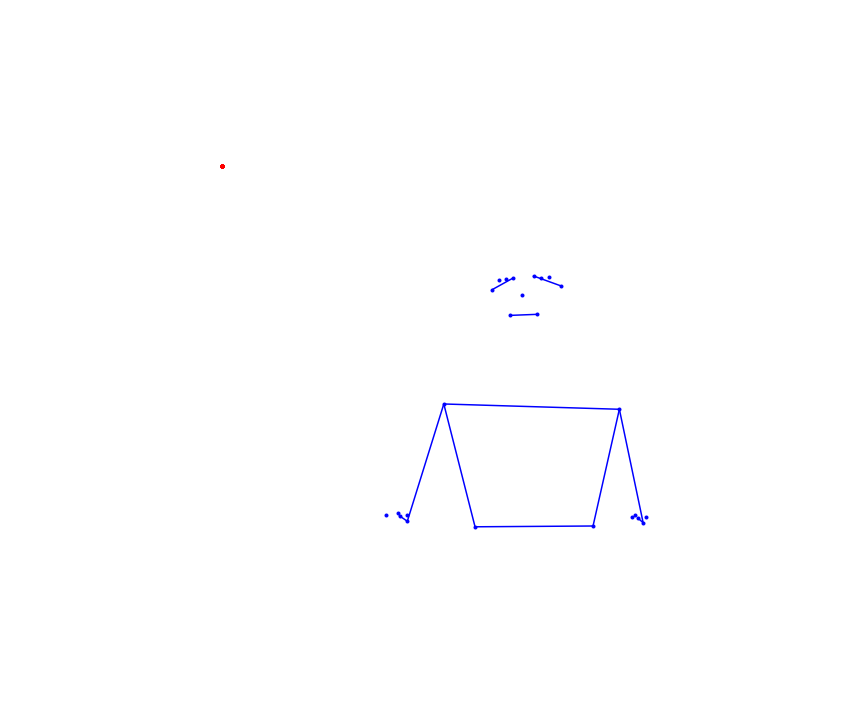

In [70]:
#@title ### Escoja el la salva del modelo y la palabra a escoger
ckpt_name = "generacion-lsc_0000" #@param ["generacion-lsc_0000", "generacion-lsc_0001"]
word = "por la ma\xF1ana" #@param {type:"string"}
save_video = True #@param {type:"boolean"}
video_name = "por_la_ma\xF1ana _target" #@param {type:"string"}

checkpoint_index = f"{ckpt_name}.ckpt.index"
checkpoint_data = f"{ckpt_name}.ckpt.data-00000-of-00001"

checkpoint_index_path = Path(f"./{checkpoint_index}")
checkpoint_index_path.resolve().touch(exist_ok=True)

checkpoint_data_path = Path(f"./{checkpoint_data}")
checkpoint_data_path.resolve().touch(exist_ok=True)

s3_client.download_file("lsc-corpus",f"tesis-generacion-lsc/{checkpoint_index}",str(checkpoint_index_path))
s3_client.download_file("lsc-corpus",f"tesis-generacion-lsc/{checkpoint_data}",str(checkpoint_data_path))

model = get_model(np.zeros((1,5,400)),np.zeros((1,24,67,3)))

checkpoint = f"./{ckpt_name}.ckpt"

model.load_weights(checkpoint)

vec = np.array([get_vector(word,word_vectors,5)])

result = model.predict(vec) # Shape of (1, 24, 67, 3)

a=plotanimation(result[0])

if save_video:
  a.save(f"{video_name}.mp4")

a



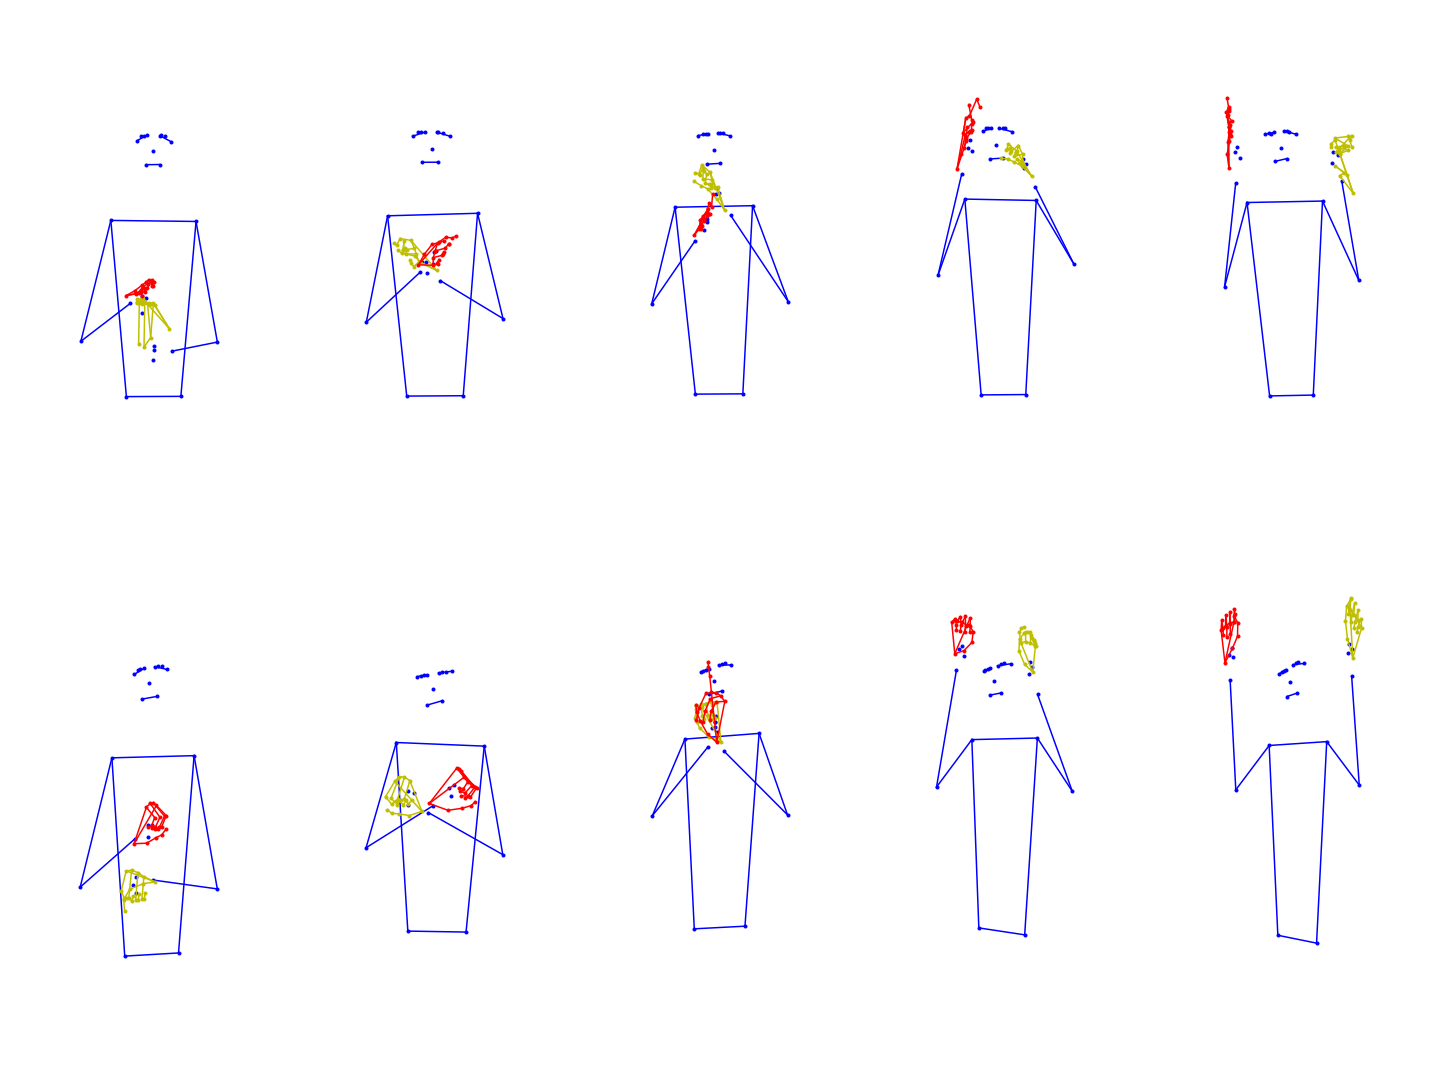

In [71]:
#@markdown ### Comparar con la frase en el dataset en caso de existir

if(word in dataset.keys()):
  VsData = np.array(dataset[word]) # Dataset values shape (1, 24, 201)
  VsData = VsData.reshape((1,24,67,3))
  compareplots(result[0][3:12:2,:,:],VsData[0][3:12:2,:,:],VsData.shape[1],figsize=(20,15),joints=True)
  plt.show()

else:
  print("Frase no encontrada")

